In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from pyspark.sql.functions import col

In [2]:
sc= SparkContext()
sqlContext = SQLContext(sc)

## Step 1. Generate some fake data

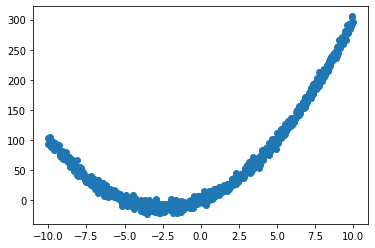

In [115]:
SIZE = 1000
x = np.random.uniform(-10, 10, size=SIZE)
y = 2 * np.square(x) + 10 * x + np.random.randn(SIZE) * 5
plt.scatter(x, y)

In [116]:
df = pd.DataFrame({'y_true': y, 'feature': x})
df.to_csv('data.csv', index=False)
df.sample(3)


,y_true,feature
514,-6.638883,-2.537854
918,16.471411,-6.005063
683,-9.639582,-1.052994


## Load data from Disk in Spark

In [191]:
data = sqlContext.read.format("csv").option("header", "true").load("data.csv")

In [192]:
data.printSchema()

root
 |-- y_true: string (nullable = true)
 |-- feature: string (nullable = true)



## Preprocessing

In [193]:
# drop none/null rows if necessary
data.na.drop()
# drop duplcates if necessary 
data = data.drop_duplicates()
# convert data types if necessary
data = data\
    .withColumn("feature", col('feature').cast("float"))\
    .withColumn("y_true", col('y_true').cast("float"))
data.printSchema()

root
 |-- y_true: float (nullable = true)
 |-- feature: float (nullable = true)



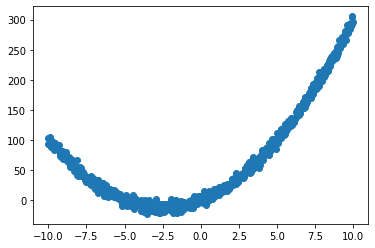

In [194]:
x = data.select('feature').collect()
y = data.select('y_true').collect()
plt.scatter(x, y)

## Feature engineering 

In [195]:
# create the second order feature 
from pyspark.sql.functions import udf

@udf("float")
def squared_udf(s):
    return float(s * s)

data = data.withColumn("feature_2", squared_udf(col('feature')))

In [196]:
data.printSchema()

root
 |-- y_true: float (nullable = true)
 |-- feature: float (nullable = true)
 |-- feature_2: float (nullable = true)



In [197]:
# prepare the data into two columns: features and label 
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['feature', 'feature_2'],
                                  outputCol = 'features')

data = vectorAssembler.transform(data).select('features', 'y_true')

In [198]:
data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- y_true: float (nullable = true)



## Regression

In [199]:
from pyspark.ml.regression import LinearRegression

In [200]:
lr = LinearRegression(featuresCol = 'features', 
                      labelCol='y_true')
lr_model = lr.fit(data)

## Statistics

In [201]:
print('MSE', lr_model.summary.meanSquaredError)
print('MAE', lr_model.summary.meanAbsoluteError)

MSE 24.536735081669832
MAE 4.014221819718108


## Run prediction

In [202]:
pred = lr_model.transform(data.select('features'))
pred.printSchema()

root
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [203]:
y_pred = np.array(pred.select('prediction').collect())
y_true = np.array(data.select('y_true').collect())

Text(0.5, 1.0, 'predicted')

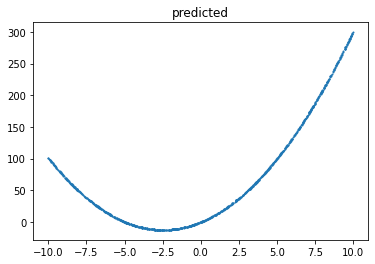

In [205]:
plt.scatter(x, y_pred, s=1)
plt.title('predicted')